In [1]:
'''
This script uses a dataset consisting of body motion parameters 
during physical activity as features and activity type as the target value 
to be predicted from features. The train set is used to build and compare
classification models using cross-validation. The model with highest accuracy
is then used to predict activity type on the test set.
'''

__author__ = "Mahsa Shokouhi"
__email__ = "mahsa_shokouhi@yahoo.com"

In [2]:
# Import packages

import pandas as pd
import numpy as np


import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              BaggingClassifier,
                              GradientBoostingClassifier,
                              HistGradientBoostingClassifier)
from sklearn.metrics import confusion_matrix, classification_report


from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline


%matplotlib inline

In [3]:
# Define functions


def plot_clusters(df, title, x, y):
    ''' Plots clusters of Activity Group after dimensionality reduction.'''
    fig = px.scatter(df, x=x, y=y, color="Activity-type",
                     hover_data=['Activity-type'],
                     color_discrete_sequence=px.colors.qualitative.Light24)
    fig.update_traces(marker=dict(size=8, line=dict(width=0.4)))
    fig.update_layout(template='plotly_white', width=1000, height=800,
                      title={'text': title, 'y': 0.97, 'x': 0.4,
                             'xanchor': 'center', 'yanchor': 'top'})
    fig.update_xaxes(showgrid=False)
    fig.update_yaxes(showgrid=False)
    fig.show()


def evaluate_model(model, x, y):
    ''' 
    Estimates the model accuracy using repeated, k-fold cross-validation 
    using training set.
    Inputs: (defined) model, x(features), y(target variable)
    Output: An array of accuracies for all n_splits*n_repeats measurements.
    '''
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    score = cross_val_score(model, x, y, scoring='accuracy',
                            cv=cv, verbose=0)
    return score


def compare_models(models, x, y):
    ''' 
    Compares accuracies of given models using training set.
    Inputs: models (to compare), x(features), y(target variable)
    Outputs: scores(an array of all accuracies for all measurement 
    and all models), mean_score (an array with the length of n_models, 
    with each element corresponding to the mean accuracy for each model), 
    std_score (an array with the length of n_models, with each element 
    corresponding to the standard deviation of scores for each model).
    '''
    scores = []
    for model in models:
        score = evaluate_model(model, x, y)
        scores.append(score)
    mean_score = np.mean(scores, axis=1)
    std_score = np.std(scores, axis=1)
    return scores, mean_score, std_score

# Data Preparation
##  Train set

In [4]:
# Get features
feature_names = [line.rstrip('\n').rstrip(' ')
                 for line in open("features.txt")]

features = pd.read_csv('Train/X_train.txt', sep=" ",
                       header=None, names=feature_names)
print(features.shape)
features.describe().transpose()

(7767, 561)


count      mean       std       min  \
tBodyAcc-Mean-1                  7767.0  0.038759  0.101996 -1.000000   
tBodyAcc-Mean-2                  7767.0 -0.000647  0.099974 -1.000000   
tBodyAcc-Mean-3                  7767.0 -0.018155  0.089927 -1.000000   
tBodyAcc-STD-1                   7767.0 -0.599017  0.441481 -1.000000   
tBodyAcc-STD-2                   7767.0 -0.634424  0.367558 -1.000000   
...                                 ...       ...       ...       ...   
tBodyGyro-AngleWRTGravity-1      7767.0  0.009239  0.601208 -1.000000   
tBodyGyroJerk-AngleWRTGravity-1  7767.0 -0.005184  0.477218 -1.000000   
tXAxisAcc-AngleWRTGravity-1      7767.0 -0.485936  0.509278 -1.000000   
tYAxisAcc-AngleWRTGravity-1      7767.0  0.050310  0.300866 -1.000000   
tZAxisAcc-AngleWRTGravity-1      7767.0 -0.052888  0.276196 -0.987874   

                                      25%       50%       75%       max  
tBodyAcc-Mean-1                  0.032037  0.038975  0.044000  1.000000  
tBodyAcc-Mean-2                 -0.011209 -0.002921  0.004303  1.000000  
tBodyAcc-Mean-3                 -0.028448 -0.019602 -0.011676  1.000000  
tBodyAcc-STD-1                  -0.992140 -0.914202 -0.246026  1.000000  
tBodyAcc-STD-2                  -0.983570 -0.827970 -0.313069  0.945956  
...                                   ...       ...       ...       ...  
tBodyGyro-AngleWRTGravity-1     -0.470267  0.001515  0.496871  0.998702  
tBodyGyroJerk-AngleWRTGravity-1 -0.373565 -0.005503  0.352690  0.991288  
tXAxisAcc-AngleWRTGravity-1     -0.810953 -0.706619 -0.488765  1.000000  
tYAxisAcc-AngleWRTGravity-1     -0.047752  0.176777  0.246834  0.482229  
tZAxisAcc-AngleWRTGravity-1     -0.140560  0.004583  0.109507  1.000000  

[561 rows x 8 columns]

In [5]:
df = pd.DataFrame(features.describe().transpose().describe())
df = df[['min', 'max']]
df.columns = [i+'_stats' for i in df.columns]
df

min_stats   max_stats
count  561.000000  561.000000
mean    -0.991599    0.968523
std      0.046512    0.090377
min     -1.000000    0.351722
25%     -1.000000    1.000000
50%     -1.000000    1.000000
75%     -1.000000    1.000000
max     -0.493925    1.000000

In [6]:
# Get the target variable: Activity type (both labels and numerically-encoded)
labels = pd.read_csv('Train/y_train.txt', header=None,
                     names=['Activity-group'])

activity_labels = [line.rstrip('\n').rstrip(' ').split()
                   for line in open("activity_labels.txt")]
activity_labels = pd.DataFrame(data=activity_labels,
                               columns=['Activity-group', 'Activity-type'])
activity_labels['Activity-group'] = activity_labels['Activity-group'].astype(
    int)
activity = pd.merge(labels, activity_labels, how='left', on='Activity-group')

# Get subjects ID
subjects = pd.read_csv('Train/subject_id_train.txt',
                       header=None, names=['Subject_ID'])

# Create the training set
train = pd.concat([subjects, activity, features], axis=1)

print(train.shape)
train.head()

(7767, 564)


Subject_ID  Activity-group Activity-type  tBodyAcc-Mean-1  tBodyAcc-Mean-2  \
0           1               5      STANDING         0.043580        -0.005970   
1           1               5      STANDING         0.039480        -0.002131   
2           1               5      STANDING         0.039978        -0.005153   
3           1               5      STANDING         0.039785        -0.011809   
4           1               5      STANDING         0.038758        -0.002289   

   tBodyAcc-Mean-3  tBodyAcc-STD-1  tBodyAcc-STD-2  tBodyAcc-STD-3  \
0        -0.035054       -0.995381       -0.988366       -0.937382   
1        -0.029067       -0.998348       -0.982945       -0.971273   
2        -0.022651       -0.995482       -0.977314       -0.984760   
3        -0.028916       -0.996194       -0.988569       -0.993256   
4        -0.023863       -0.998241       -0.986774       -0.993115   

   tBodyAcc-Mad-1  ...  fBodyGyroJerkMag-MeanFreq-1  \
0       -0.995007  ...                    -0.012236   
1       -0.998702  ...                     0.202804   
2       -0.996415  ...                     0.440079   
3       -0.996994  ...                     0.430891   
4       -0.998216  ...                     0.137735   

   fBodyGyroJerkMag-Skewness-1  fBodyGyroJerkMag-Kurtosis-1  \
0                    -0.314848                    -0.713308   
1                    -0.603199                    -0.860677   
2                    -0.404427                    -0.761847   
3                    -0.138373                    -0.491604   
4                    -0.366214                    -0.702490   

   tBodyAcc-AngleWRTGravity-1  tBodyAccJerk-AngleWRTGravity-1  \
0                   -0.112754                        0.030400   
1                    0.053477                       -0.007435   
2                   -0.118559                        0.177899   
3                   -0.036788                       -0.012892   
4                    0.123320                        0.122542   

   tBodyGyro-AngleWRTGravity-1  tBodyGyroJerk-AngleWRTGravity-1  \
0                    -0.464761                        -0.018446   
1                    -0.732626                         0.703511   
2                     0.100699                         0.808529   
3                     0.640011                        -0.485366   
4                     0.693578                        -0.615971   

   tXAxisAcc-AngleWRTGravity-1  tYAxisAcc-AngleWRTGravity-1  \
0                    -0.841559                     0.179913   
1                    -0.845092                     0.180261   
2                    -0.849230                     0.180610   
3                    -0.848947                     0.181907   
4                    -0.848164                     0.185124   

   tZAxisAcc-AngleWRTGravity-1  
0                    -0.051718  
1                    -0.047436  
2                    -0.042271  
3                    -0.040826  
4                    -0.037080  

[5 rows x 564 columns]

In [7]:
# Check for missing values
train.isnull().values.any()

False

In [8]:
# Get the number and percentage of observations in each class (activity group)
cnt = train['Activity-type'].value_counts()
pct = cnt / train.shape[0]
pd.DataFrame({'Count': cnt, 'Percentage': pct})

Count  Percentage
STANDING             1423    0.183211
LAYING               1413    0.181924
SITTING              1293    0.166474
WALKING              1226    0.157847
WALKING_UPSTAIRS     1073    0.138149
WALKING_DOWNSTAIRS    987    0.127076
STAND_TO_LIE           90    0.011587
SIT_TO_LIE             75    0.009656
LIE_TO_SIT             60    0.007725
LIE_TO_STAND           57    0.007339
STAND_TO_SIT           47    0.006051
SIT_TO_STAND           23    0.002961

In [9]:
# Define X (features) and y (target) for model training
X = train[train.columns[3:]]
y = train['Activity-group']

## Test Set

In [10]:
X_test = pd.read_csv('Test/X_test.txt', sep=" ",
                       header=None, names=feature_names)
y_test = pd.read_csv('Test/y_test.txt', header=None,
                     names=['Activity-group'])

y_test_labels = pd.merge(y_test, activity_labels, how='left', on='Activity-group')

print(X_test.shape, y_test.shape)

(3162, 561) (3162, 1)


## Compare Train and Test Sets

In [11]:
# Check if there's an overlap between subjects in train and test sets

subjects_test = pd.read_csv('Test/subject_id_test.txt',
                            header=None, names=['Subject_ID'])

print('Train set subject IDs:', np.unique(subjects['Subject_ID']))
print('Test set subject IDs:', np.unique(subjects_test['Subject_ID']))

overlap = list(set(subjects['Subject_ID']) & set(subjects_test['Subject_ID']))
print(f'there are {len(overlap)} common subjects in train and test sets')

Train set subject IDs: [ 1  3  5  6  7  8 11 14 15 16 17 19 21 22 23 25 26 27 28 29 30]
Test set subject IDs: [ 2  4  9 10 12 13 18 20 24]
there are 0 common subjects in train and test sets


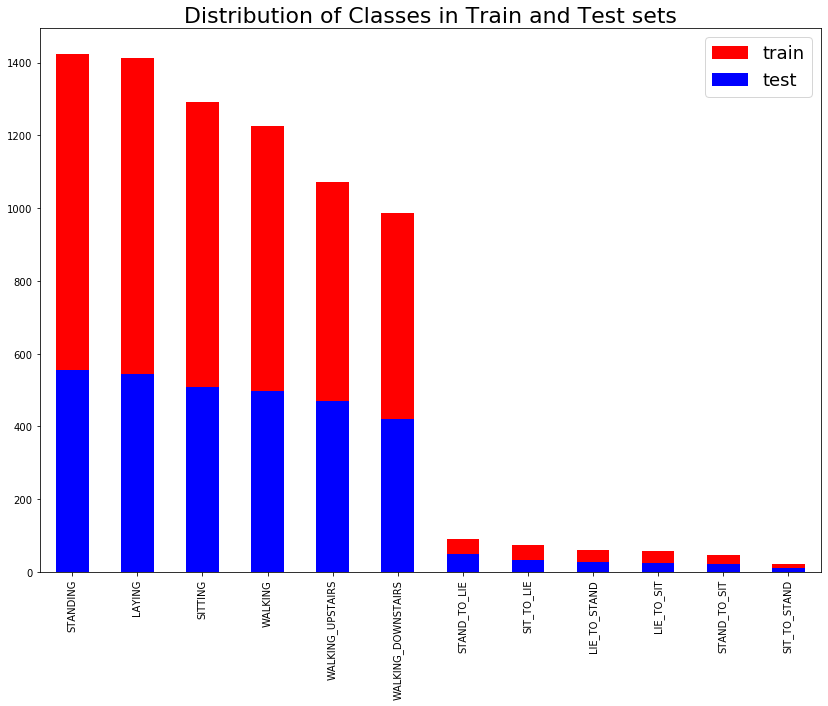

In [12]:
# Compare the distribution of classes in train and test set

plt.figure(figsize=(14, 10))
train['Activity-type'].value_counts().plot(kind='bar',
                                           color='r', label='train')
y_test_labels['Activity-type'].value_counts().plot(kind='bar',
                                                   color='b', label='test')
plt.legend(prop={'size': 18})
plt.title('Distribution of Classes in Train and Test sets', fontsize=22);

# Exploratory Data Analysis

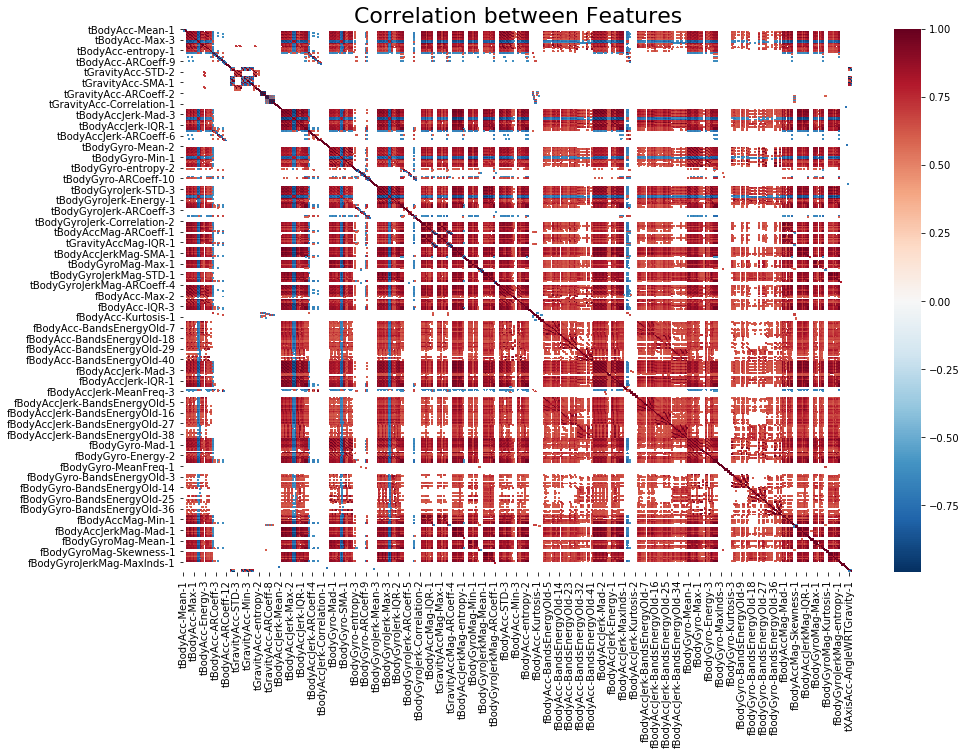

In [13]:
# Correlation between features

X_corr = X.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(X_corr[abs(X_corr) > 0.6], cmap="RdBu_r");
plt.title('Correlation between Features', fontsize=22, y=2);

## Clustering

In [14]:
# Dimensionality reduction using LDA
lda = LinearDiscriminantAnalysis()
LDs = lda.fit_transform(X, y)
LDs = LDs[:,:2] # the first two LDA components


# Create a dataframe for plotting the clusters
plot_df = pd.concat(
    [train['Activity-group'], train['Activity-type'],
     pd.DataFrame(LDs, columns=['LD1', 'LD2'])],
    axis=1)

# Plot the first two LDA components
plot_clusters(plot_df,'Dimensionality reduction using LDA','LD1', 'LD2')

# Classification Model Selection
## Baseline Model

In [15]:
# Naive Algorithm: choose majority class

dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_score = evaluate_model(dummy_clf, X, y)
# Mean accuracy will be the same as the distribution of the most common class
print(np.mean(dummy_score), np.std(dummy_score))

0.1832109729083329 0.0002802214756316469


## Spot-Check Classification Algorithms
Preliminary comparison of different algorithms

In [16]:
# 1. Linear Algorithms

models_linear = [LogisticRegression(solver='lbfgs', multi_class='multinomial', 
                                    max_iter=4000),
                 LinearDiscriminantAnalysis(),
                 SVC(kernel='linear'),
                 GaussianNB()]

scores_lin, mean_score_lin, std_score_lin = compare_models(models_linear, X, y)

rows = [type(model).__name__ for model in models_linear]
accuracy_lin = pd.DataFrame(mean_score_lin,
                            index=rows, columns=['Imbalanced'])
accuracy_lin

Imbalanced
LogisticRegression            0.975366
LinearDiscriminantAnalysis    0.971761
SVC                           0.978241
GaussianNB                    0.710914

In [17]:
# 2. Nonlinear Algorithms

models_nonlin = [SVC(gamma='scale'),
                 KNeighborsClassifier(),
                 DecisionTreeClassifier()]

scores_nonlin, mean_score_nonlin, std_score_nonlin = compare_models(
    models_nonlin, X, y)
rows = [type(model).__name__ for model in models_nonlin]
accuracy_nonlin = pd.DataFrame(mean_score_nonlin,
                               index=rows, columns=['Imbalanced'])
accuracy_nonlin

Imbalanced
SVC                       0.960731
KNeighborsClassifier      0.952406
DecisionTreeClassifier    0.916184

In [18]:
# 3. Ensemble Algorithms

models_ensemble = [BaggingClassifier(),
                   RandomForestClassifier(),
                   ExtraTreesClassifier(),
                   HistGradientBoostingClassifier()]

scores_ensemble, mean_score_ensemble, std_score_ensemble = compare_models(
    models_ensemble, X, y)

rows = [type(model).__name__ for model in models_ensemble]
accuracy_ensemble = pd.DataFrame(mean_score_ensemble,
                                 index=rows, columns=['Imbalanced'])
accuracy_ensemble

Imbalanced
BaggingClassifier                 0.949058
RandomForestClassifier            0.966868
ExtraTreesClassifier              0.971761
HistGradientBoostingClassifier    0.421110

In [19]:
# filter and combine algorithms
accuracy_table = pd.concat([accuracy_lin, accuracy_ensemble], axis=0)
accuracy_table = accuracy_table [accuracy_table.values >= 0.97]

accuracy_table

Imbalanced
LogisticRegression            0.975366
LinearDiscriminantAnalysis    0.971761
SVC                           0.978241
ExtraTreesClassifier          0.971761

## Balanced Algorithms with Data Resampling

In [20]:
# Select superior models from previous section
models = [LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=4000),
          LinearDiscriminantAnalysis(),
          SVC(kernel='linear'),
          ExtraTreesClassifier()]

In [21]:
# Data Resampling using SMOTE and ADASYN

pipe_SMOTE = [Pipeline(list((('o', SMOTE(random_state=100)), ('m', model))))
              for model in models]
scores_SMOTE, mean_score_SMOTE, std_score_SMOTE = compare_models(
    pipe_SMOTE, X, y)
accuracy_SMOTE = pd.DataFrame(mean_score_SMOTE,
                              index=[type(model).__name__ for model in models],
                              columns=['SMOTE'])


pipe_ADASYN = [Pipeline(list((('o', ADASYN(random_state=100)), ('m', model))))
               for model in models]
scores_ADASYN, mean_score_ADASYN, std_score_ADASYN = compare_models(
    pipe_ADASYN, X, y)
accuracy_ADASYN = pd.DataFrame(mean_score_ADASYN,
                               index=[
                                   type(model).__name__ for model in models],
                               columns=['ADASYN'])

accuracy_table = pd.concat([accuracy_table, accuracy_SMOTE, accuracy_ADASYN], 
                           axis=1)
accuracy_table

Imbalanced     SMOTE    ADASYN
LogisticRegression            0.975366  0.975752  0.975538
LinearDiscriminantAnalysis    0.971761  0.968971  0.970345
SVC                           0.978241  0.978156  0.978327
ExtraTreesClassifier          0.971761  0.975066  0.975237

## Dimensionality Reduction

In [22]:
# Compare dimensionality reduction with LDA and PCA

pipe_lda = [Pipeline(list((('lda', LinearDiscriminantAnalysis()), ('m', model))))
            for model in models]
scores_lda, mean_score_lda, std_score_lda = compare_models(pipe_lda, X, y)
accuracy_lda = pd.DataFrame(mean_score_lda,
                            index=[type(model).__name__ for model in models],
                            columns=['LDA'])


pipe_pca = [Pipeline(list((('pca', PCA()), ('m', model))))
            for model in models]
scores_pca, mean_score_pca, std_score_pca = compare_models(pipe_pca, X, y)
accuracy_pca = pd.DataFrame(mean_score_pca,
                            index=[type(model).__name__ for model in models],
                            columns=['PCA'])

accuracy_table = pd.concat(
    [accuracy_table, accuracy_lda, accuracy_pca], axis=1)

accuracy_table

Imbalanced     SMOTE    ADASYN       LDA       PCA
LogisticRegression            0.975366  0.975752  0.975538  0.972362  0.975409
LinearDiscriminantAnalysis    0.971761  0.968971  0.970345  0.971761  0.971933
SVC                           0.978241  0.978156  0.978327  0.972061  0.978284
ExtraTreesClassifier          0.971761  0.975066  0.975237  0.974293  0.872108

## Hyperparameter Tuning for Cost-Sensitive Algorithms

In [24]:
# Logistic Regression
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial',
                        max_iter=4000, C=1.0, class_weight='balanced')

model_lr = Pipeline(steps=[('pca', PCA()), ('m', lr)])
score_lr = evaluate_model(model_lr, X, y)
np.mean(score_lr)

0.975237476460915

In [25]:
# Linear SVC
model_svc = SVC(kernel='linear', C=1.0, class_weight='balanced')
score_svc = evaluate_model(model_svc, X, y)
np.mean(score_svc)

0.977726590540499

In [26]:
# ExtraTree Classifier
model_et = ExtraTreesClassifier(n_estimators=300, max_depth=50,
                                class_weight='balanced')
score_et = evaluate_model(model_et, X, y)
np.mean(score_et)

0.9749794684759271

In [27]:
# Selected model
selected_model = model_svc

# Activity Prediction for Test Set

In [28]:
selected_model.fit(X,y)
y_test_pred = selected_model.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           1       0.96      0.99      0.98       496
           2       0.98      0.97      0.97       471
           3       0.99      0.98      0.98       420
           4       0.96      0.89      0.92       508
           5       0.91      0.97      0.94       556
           6       1.00      1.00      1.00       545
           7       0.95      0.78      0.86        23
           8       0.91      1.00      0.95        10
           9       0.58      0.66      0.62        32
          10       0.75      0.72      0.73        25
          11       0.70      0.65      0.67        49
          12       0.72      0.67      0.69        27

    accuracy                           0.95      3162
   macro avg       0.87      0.86      0.86      3162
weighted avg       0.95      0.95      0.95      3162

